# Comparisons to More Inclusive Putative Event Boundaries- Jaccard Analysis of Segmentation Data
### 11/4/20
### Permuting already calculated jaccard indices instead of recalculating them inside each permutation

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
import random
from sklearn.metrics import jaccard_score
%autosave 5

Autosaving every 5 seconds


### i. Import data

In [2]:
filename = '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/analysis/segment/usable_data'
data_dict = pickle.load( open( filename, "rb" ) )
filename_sums = '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/analysis/segment/sums_usable_data'
sums = pickle.load( open( filename_sums, "rb" ) )
len(data_dict)

316

### ii. import and organize story files
#### a. Import file

In [3]:
directory_stories = '/Users/alexreblando/Documents/GitHub/ebs/fMRI experiment/11:3:20_more_inclusive_boundaries'

filenames_stories = glob.glob(directory_stories + '/*.xlsx')

dfs_stories = []
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_excel(filename))

#### b. organize putative event boundaries

In [4]:
#mark the boundaries with a '1'
#output: story_boundaries, where the first column has the location boundaries and the second column has the social
#boundaries

story_boundaries_raw = dict()

#read in the location and social event values from the story files 
for s in range(16):
    this_story = int(dfs_stories[s]['story'].iloc[0])
    keys2 = dfs_stories[s]['locationEvent'].values
    keys3 = dfs_stories[s]['socialEvent'].values
    story_boundaries_raw[this_story] = keys2[:, np.newaxis]
    story_boundaries_raw[this_story] = np.concatenate((story_boundaries_raw[this_story], keys3[:, np.newaxis]), axis = 1)
    


In [5]:
story_boundaries = {}

for key in story_boundaries_raw:
    location = story_boundaries_raw[key][:,0]
    social = story_boundaries_raw[key][:,1]
    new_vec_loc = np.zeros((len(location)))
    new_vec_soc = np.zeros((len(social)))
    for i in range(0, len(location)):  
        if location[i] > location[i-1]:
            new_vec_loc[i] = 1
    for i in range(0, len(social)):
        if social[i] > social[i - 1]:
            new_vec_soc[i] = 1
    location2 = new_vec_loc.astype(int)
    social2 = new_vec_soc.astype(int)
    story_boundaries[key] = np.column_stack((location2, social2))

In [6]:
story_boundaries[12].shape

(31, 2)

# II. Separating the Priming Groups For Each Story
## A. group stories by subject and priming type
#### - output: loc_keys_r

In [7]:
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for key in data_dict:
    this_story = data_dict[key]['story'].iloc[0]
    keys = data_dict[key]['story_presses']
    p_type = data_dict[key]['p_type'].iloc[0]
    #print out the filenames and prolific ids of people who did not press "9" once
    occurrences = np.count_nonzero(keys == 9)
    if occurrences == 0:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 0:
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 1:
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 2:
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]

## B. Convert keypresses from '9's and '1's to '1's and '0's
#### - output loc_keys
#### - WARNING: you can only run this once!!!!!! if you run twice, you must start from the beginning

In [8]:
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   

## C. Remove first sentence (first row) from all keypresses

In [9]:
list_keys = [all_keys, none_keys, loc_keys, soc_keys]
for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        list_keys[i][key] = np.delete(list_keys[i][key],(0), axis = 0)

## D. Remove first sentence (first row) from all a priori story boundaries

In [10]:
for key in story_boundaries:
    story_boundaries[key] = np.delete(story_boundaries[key],(0), axis = 0)

In [11]:
story_boundaries[42]

array([[0, 0],
       [0, 0],
       [0, 1],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0]])

# III. Jaccard Analysis
## A. Compare priming types of each story to putative event boundaries
### For each comparison:
#### 1) create a new vector w length the same as that of keypress vector
#### 2) compare keypress and putative event boundary, putting 1 in the new vector if indexed values in both compared vectors are 1
#### 3) remove a '1' in the new vector if it is preceded by another 1
#### 4) Jaccard analysis: # of '1's / total # of keypresses + (4 - numerator)

In [12]:
jaccard_vals = {}

list_keys = [none_keys, loc_keys, soc_keys]

for key in all_keys:
    # Making array stored in jaccard_vals
    this_array = np.zeros ((2,3))
    # Iterating through all conditions
    for i in range(len(list_keys)):
        # Iterating through location and social putative boundaries
        for j in range(0,2):
            # Finding the number of participants in this condition
            n = list_keys[i][key].shape[1]
            # Initiating list to add jaccard values to
            these_vals = []
            for k in range(0,n):
                subj_k = list_keys[i][key].T[k]
                put_b = story_boundaries[key].T[j]
                # Jaccard Calc
                # Step 1
                comp_vec = np.zeros((put_b.shape[0]))
                # Step 2
                for m in range(0, put_b.shape[0]):
                    if subj_k[m] == 1 and put_b[m] == 1:
                        comp_vec[m] = 1
                # Step 3
                for n in range(0, put_b.shape[0]):
                    if comp_vec[n] == 1 and comp_vec[n-1] == 1:
                        comp_vec[n] = 0
                # Step 4
                num = np.sum(comp_vec)
                denom = np.sum(subj_k) + (4 - num)
                these_vals.append(num/denom)
            # Averaging Jaccard Indices
            avg_val = sum(these_vals) / len(these_vals)
            # Putting average in this_array
            this_array[j, i] = avg_val
    # Putting this_array in jaccard_vals
    jaccard_vals[key] = this_array  

## B. Plotting

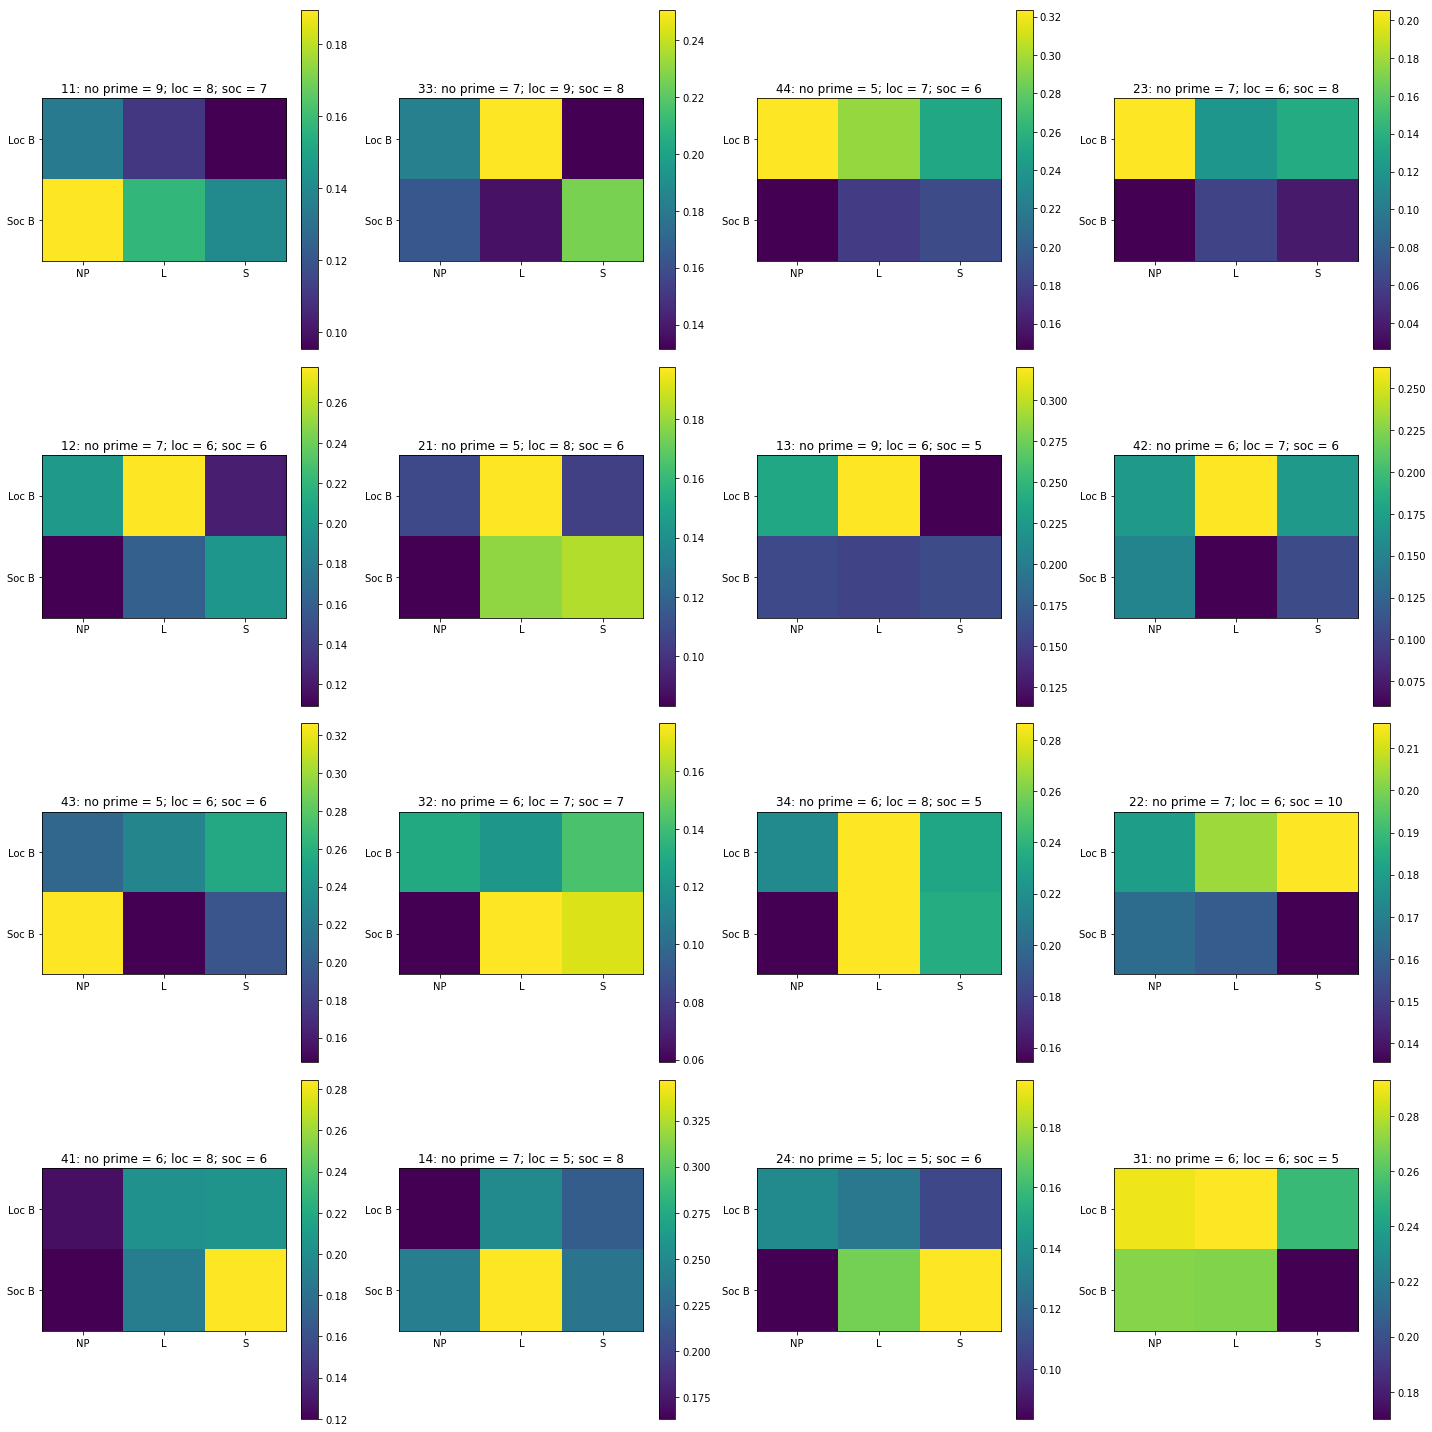

In [13]:
figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

i = 0
j = 0
for key in jaccard_vals:
    # Make the plot
    im = axes[j, i].imshow(jaccard_vals[key])
    
    #colorbar
    im.set_clim()
    figure.colorbar(im, ax=axes[j, i])
    
    #set title
    none_n = sums[key][1]
    loc_n = sums[key][2]
    soc_n = sums[key][3]
    axes[j, i].set_title(str(key) + ': no prime = ' + str(none_n) + '; loc = ' + str(loc_n) + '; soc = ' + str(soc_n))
    
    # X ticks
    x_label_list = ['NP', 'L', 'S']
    axes[j, i].set_xticks([0,1,2])
    axes[j, i].set_xticklabels(x_label_list)
    
    # Y ticks
    y_label_list = ['Loc B', 'Soc B']
    axes[j, i].set_yticks([0,1])
    axes[j, i].set_yticklabels(y_label_list)
     
    #changing i, j for next graph placement
    if i == 3:
        i = 0
        j += 1
    else:
        i += 1
    figure.tight_layout()

## C. Average Jaccard Values across all story avgs
### - this is the average of the 16 story values, not the data points that make those up. 

In [14]:
count = 0

for key in jaccard_vals:
    if count == 0:
        all_j_vals = jaccard_vals[key]
        count =+ 1
    else:
        all_j_vals = np.dstack((all_j_vals, jaccard_vals[key]))

# NanMean
avg_all_j_vals = np.nanmean(all_j_vals, axis = 2)

## D. Plot

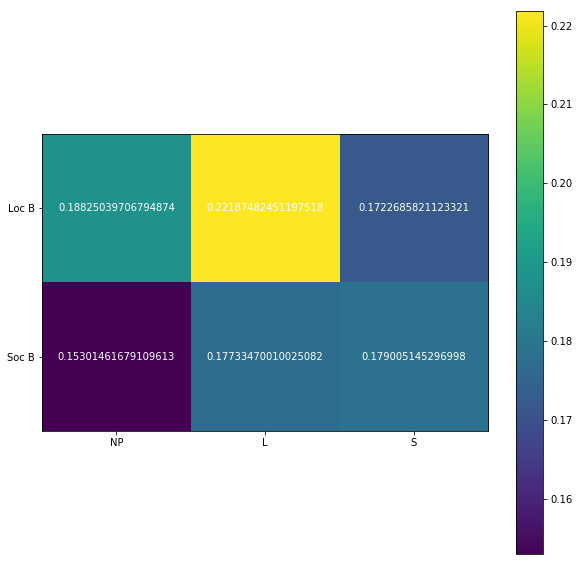

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_all_j_vals)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['Loc B', 'Soc B']
ax.set_yticks([0,1])
ax.set_yticklabels(y_label_list)

# Adding values to boxes
# Loop over data dimensions and create text annotations.
for i in range(0, 3):
    for j in range(0, 2):
        text = ax.text(i, j, avg_all_j_vals[j, i], ha="center", va="center", color="w")

## E. Average Jaccard Values calculated from all the data points within the story avgs

In [19]:
jaccard_vals = {}

list_keys = [none_keys, loc_keys, soc_keys]
n_l = []
l_l = []
s_l = []
n_s = []
l_s = []
s_s = []

list_vals = [[n_l, l_l, s_l], [n_s, l_s, s_s]]

for key in all_keys:
    # Making array stored in jaccard_vals
    this_array = np.zeros ((2,3))
    # Iterating through all conditions
    for i in range(len(list_keys)):
        # Iterating through location and social putative boundaries
        for j in range(0,2):
            # Finding the number of participants in this condition
            n = list_keys[i][key].shape[1]
            # Initiating list to add jaccard values to
            these_vals = []
            for k in range(0,n):
                subj_k = list_keys[i][key].T[k]
                put_b = story_boundaries[key].T[j]
                # Jaccard Calc
                # Step 1
                comp_vec = np.zeros((put_b.shape[0]))
                # Step 2
                for m in range(0, put_b.shape[0]):
                    if subj_k[m] == 1 and put_b[m] == 1:
                        comp_vec[m] = 1
                # Step 3
                for n in range(0, put_b.shape[0]):
                    if comp_vec[n] == 1 and comp_vec[n-1] == 1:
                        comp_vec[n] = 0
                # Step 4
                num = np.sum(comp_vec)
                denom = np.sum(subj_k) + (4 - num)
                list_vals[j][i].append(num/denom)

avg_points_actual = np.zeros((2, 3))
for i in range(0,2):
    for j in range(0,3):
        this_avg = sum(list_vals[i][j])/len(list_vals[i][j])
        avg_points_actual[i,j] = this_avg

In [20]:
print(len(n_l))

101


## F. Plotting

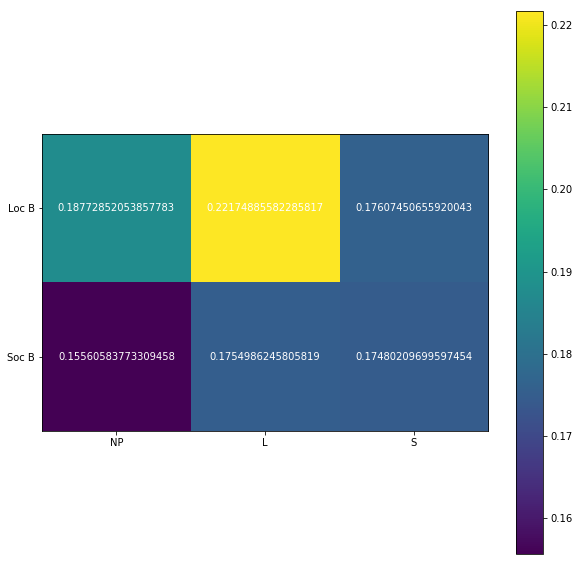

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_points_actual)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['Loc B', 'Soc B']
ax.set_yticks([0,1])
ax.set_yticklabels(y_label_list)

# Adding values to boxes
# Loop over data dimensions and create text annotations.
for i in range(0, 3):
    for j in range(0, 2):
        text = ax.text(i, j, avg_points_actual[j, i], ha="center", va="center", color="w")

# V. Permutation Testing
## A. Get a 2 X all participant matrix for each story with JI comparing each participant to each type of boundary

In [22]:
# Get JI for all 3 types of primed participants and then put in a single matrix for each story 

JIs = {}

for key in all_keys:
    print(key)
    # instantiate empty JI_matrix
    this_JI = np.zeros((2, sums[key][0]))
    # Iterate through loc and soc boundaries (Loc - 0, Soc - 1)
    for j in range(0, 2):
        # Instantiate count, which will index this matrix
        count = 0
        # Go through NP participants
        for i in range(0, none_keys[key].shape[1]):
            # Get the column
            this_col = none_keys[key][:, i]
            # Get putative boundary
            put_b = story_boundaries[key].T[j]
            # Calculate JI with boundary
            # Step 1
            comp_vec = np.zeros((put_b.shape[0]))
            # Step 2
            for m in range(0, put_b.shape[0]):
                if this_col[m] == 1 and put_b[m] == 1:
                    comp_vec[m] = 1
            # Step 3
            for n in range(0, put_b.shape[0]):
                if comp_vec[n] == 1 and comp_vec[n-1] == 1:
                    comp_vec[n] = 0
            # Step 4
            num = np.sum(comp_vec)
            denom = np.sum(subj_k) + (4 - num)
            # Put this_one in this_JI
            this_JI[j, count] = num/denom
            # Increase the counter
            count += 1
        # Go through L participants
        for i in range(0, loc_keys[key].shape[1]):
            # Get the column
            this_col = loc_keys[key][:, i]
            # Get putative boundary
            put_b = story_boundaries[key].T[j]
            # Calculate JI with boundary
            # Step 1
            comp_vec = np.zeros((put_b.shape[0]))
            # Step 2
            for m in range(0, put_b.shape[0]):
                if this_col[m] == 1 and put_b[m] == 1:
                    comp_vec[m] = 1
            # Step 3
            for n in range(0, put_b.shape[0]):
                if comp_vec[n] == 1 and comp_vec[n-1] == 1:
                    comp_vec[n] = 0
            # Step 4
            num = np.sum(comp_vec)
            denom = np.sum(subj_k) + (4 - num)
            # Put this_one in this_JI
            this_JI[j, count] = num/denom
            # Increase the counter
            count += 1
        for i in range(0, soc_keys[key].shape[1]):
            # Get the column
            this_col = soc_keys[key][:, i]
            # Get putative boundary
            put_b = story_boundaries[key].T[j]
            # Calculate JI with boundary
            # Step 1
            comp_vec = np.zeros((put_b.shape[0]))
            # Step 2
            for m in range(0, put_b.shape[0]):
                if this_col[m] == 1 and put_b[m] == 1:
                    comp_vec[m] = 1
            # Step 3
            for n in range(0, put_b.shape[0]):
                if comp_vec[n] == 1 and comp_vec[n-1] == 1:
                    comp_vec[n] = 0
            # Step 4
            num = np.sum(comp_vec)
            denom = np.sum(subj_k) + (4 - num)
            # Put this_one in this_JI
            this_JI[j, count] = num/denom
            # Increase the counter
            count += 1
    JIs[key] = this_JI
        
        
        
        
    

11
33
44
23
12
21
13
42
43
32
34
22
41
14
24
31


In [23]:
print(JIs[key])
print(sums[key][3])
print(JIs[key][:, (sums[key][1] + sums[key][2]): sums[key][0]])

[[0.6        0.33333333 0.33333333 0.33333333 0.6        0.33333333
  0.6        0.6        0.6        0.6        0.6        0.
  0.6        0.6        0.         0.6        0.14285714]
 [0.33333333 0.6        0.14285714 0.6        0.33333333 0.6
  0.6        0.6        0.33333333 0.33333333 0.6        0.14285714
  0.6        0.14285714 0.         0.6        0.        ]]
5
[[0.6        0.6        0.         0.6        0.14285714]
 [0.6        0.14285714 0.         0.6        0.        ]]


In [24]:
sums[11]

[24, 9, 8, 7]

In [25]:
with open('JIs.pickle', 'wb') as handle:
    pickle.dump(JIs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('sums.pickle', 'wb') as handle:
    pickle.dump(sums, handle, protocol=pickle.HIGHEST_PROTOCOL)

## B. Permutations
### - shuffle arrays in JIs
### - to calculate the 2 X 3 arrays for each story, concatenate all the participants for each type, and then avg

In [26]:
N_perms = 10000
count = 0
better_primed = []
priming_interaction = []

for i in range(0, N_perms):
    # Permute the order of arrays in JIs
    rp_JIs = {}
    
    for key in JIs:
        # Make a copy of JI array
        this_JI = np.copy(JIs[key])
        # Generate a permutation
        randperm = np.random.permutation(sums[key][0])
        # Shuffle columns and put in rp_JIs
        rp_JIs[key] = this_JI[:, randperm]
        
    # Instantiate NP, S, L participant groupings
    NPs = np.zeros((2,0))
    Ls = np.zeros((2,0))
    Ss = np.zeros((2,0))
    
    # Add participants from other stories
    for key in JIs:
        NPs = np.concatenate((NPs, rp_JIs[key][:, 0:sums[key][1]]), axis = 1)
        Ls = np.concatenate((Ls, rp_JIs[key][:, sums[key][1]:(sums[key][1] + sums[key][2])]), axis = 1)
        Ss = np.concatenate((Ss, rp_JIs[key][:, (sums[key][1] + sums[key][2]): sums[key][0]]), axis = 1)
    
    ##Checking if there's the same number of people in each group: yes
    #print(Ls.shape, Ss.shape)
    #print(Ss)
    
    # Average across all the arrays and concatenate to get a 2X3 matrix
    mean_np = np.mean(NPs, axis = 1)
    mean_l = np.mean(Ls, axis = 1)
    mean_s = np.mean(Ss, axis = 1)
    
    #Instatiate 2 x 3 avg_points
    avg_points = np.zeros((2,3))
    
    # Make 2 x 3 matrix
    for i in range(0,2):
        avg_points[i, 0] = mean_np[i]
        avg_points[i, 1] = mean_l[i]
        avg_points[i, 2] = mean_s[i]
        
    # Concatenate the 2 X 3 matrices of different permutations
    if count == 0:
        all_avg_points = avg_points
        count += 1
    else:
        all_avg_points = np.dstack((all_avg_points, avg_points))
        
    # Calculate and concatenate the statistics
    ## Is there a better matching to boundaries when primed?
    ## 2 - 1 + 6 - 4
    better_primed.append(avg_points[0,1] - avg_points[0,0] + avg_points[1,2] - avg_points[1, 0])
    
    ## Among people who were primed is there an interaction between the priming?
    ## 2 - 3 + 6 - 5
    priming_interaction.append(avg_points[0,1] - avg_points[0,2] + avg_points[1,2] - avg_points[1, 1])

## B. Average the jaccard values along third dimension and plot

[[0.3022419  0.30719006 0.30147612]
 [0.26916963 0.27478262 0.27224696]]


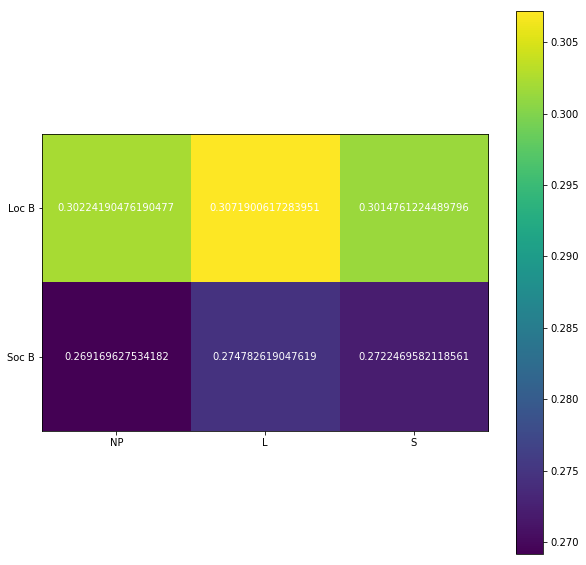

In [27]:
avg_perm = np.mean(all_avg_points, axis = 2)
print(avg_perm)

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_perm)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['Loc B', 'Soc B']
ax.set_yticks([0,1])
ax.set_yticklabels(y_label_list)

# Adding values to boxes
# Loop over data dimensions and create text annotations.
for i in range(0, 3):
    for j in range(0, 2):
        text = ax.text(i, j, avg_perm[j, i], ha="center", va="center", color="w")

## C. Priming effect of matching to Boundaries
## 2 - 1 + 6- 4
### 1. Calculate the priming effect for the actual data

In [28]:
actual_val_pe = avg_points_actual[0,1] - avg_points_actual[0,0] + avg_points_actual[1,2] - avg_points_actual[1, 0]

### 2. Plot a historgram of permuted priming effects and the actual priming effect

The p value is  0.1316


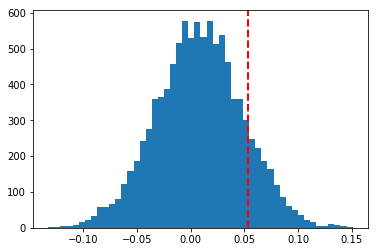

In [29]:
# convert list of PEs to np
PEs = np.asarray(better_primed)
# Plot the histogram
plt.hist(PEs, bins = 50)
# Show the actual data
plt.axvline(x=actual_val_pe, color='r', linestyle='dashed', linewidth=2)
# Calculate the P-value
p_val = ((PEs > actual_val_pe).sum())/10000
print('The p value is ', p_val)

## D. Interaction between priming
### 1. Calculate the interaction for the actual data

In [30]:
actual_val_intrct = avg_points_actual[0,1] - avg_points_actual[0,2] + avg_points_actual[1,2] - avg_points_actual[1, 1]

### 2. Plot a historgram of permuted priming effects and the actual priming effect

The p value is  0.0993


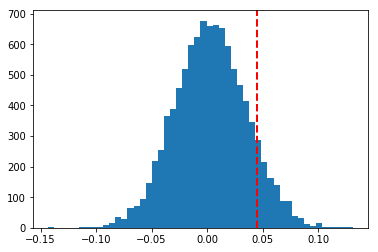

In [31]:
# convert list of PEs to np
Intrcts = np.asarray(priming_interaction)
# Plot the histogram
plt.hist(Intrcts, bins = 50)
# Show the actual data
plt.axvline(x=actual_val_intrct, color='r', linestyle='dashed', linewidth=2)
# Calculate the P-value
p_val = ((Intrcts > actual_val_intrct).sum())/10000
print('The p value is ', p_val)